In [1]:
# opengrid imports
from opengrid.library import misc, houseprint, caching
from opengrid.library.analysis import DailyAgg
from opengrid import config
c=config.Config()

# other imports
import pandas as pd
import charts
import numpy as np
import os
import datetime as dt
import pytz
BXL = pytz.timezone('Europe/Brussels')


# configuration for the plots
DEV = c.get('env', 'type') == 'dev' # DEV is True if we are in development environment, False if on the droplet
print("Environment configured for development: {}".format(DEV))
if not DEV:
    # production environment: don't try to display plots
    import matplotlib
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, HourLocator, DateFormatter, AutoDateLocator, num2date

if DEV:
    if c.get('env', 'plots') == 'inline':
        %matplotlib inline
    else:
        %matplotlib qt
else:
    pass # don't try to render plots
plt.rcParams['figure.figsize'] = 12,8

Server running in the folder /usr/local/opengrid/notebooks/Analysis at 127.0.0.1:43667
Environment configured for development: True


In [2]:
hp = houseprint.Houseprint()
sensors = hp.get_sensors(sensortype='electricity') # sensor objects

# Remove some sensors
exclude = [
            '565de0a7dc64d8370aa321491217b85f' # 3E
          ]
solar = [x.key for x in hp.search_sensors(type='electricity', system='solar')]
exclude += solar

for s in sensors:
    if s.key in exclude:
        sensors.remove(s)

hp.init_tmpo()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
24 Sites created
24 Devices created
75 sensors created
Houseprint parsing complete
Using tmpo database from /data/.tmpo/tmpo.sqlite3


In [3]:
hp.sync_tmpos()

In [ ]:
# The first time, this will take a very looong time to get all the detailed data for building the cache
# Afterwards, this is quick
starttime = dt.time(0, tzinfo=BXL)
endtime = dt.time(5, tzinfo=BXL)
caching.cache_results(hp=hp, sensors=sensors, resultname='elec_min_night_0-5', AnalysisClass=DailyAgg,  
                      agg='min', starttime=starttime, endtime=endtime)

caching.cache_results(hp=hp, sensors=sensors, resultname='elec_max_night_0-5', AnalysisClass=DailyAgg, 
                      agg='max', starttime=starttime, endtime=endtime)

This folder does not exist: /data/cache_day, it will be created
Cache object created for variable: elec_min_night_0-5


In [5]:
cache_min = caching.Cache(variable='elec_min_night_0-5')
cache_max = caching.Cache(variable='elec_max_night_0-5')
dfdaymin = cache_min.get(sensors=sensors)
dfdaymax = cache_max.get(sensors=sensors)
dfdaymin.info()

Cache object created for variable: elec_min_night_0-5
Cache object created for variable: elec_max_night_0-5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 558 entries, 2014-10-10 to 2016-04-19
Freq: D
Data columns (total 27 columns):
53b1eb0479c83dee927fff10b0cb0fe6    545 non-null float64
e1dec16012edc11de998aeaa317274d7    545 non-null float64
3aa40023a1683bfec0f01cce8d45fc70    545 non-null float64
99d7f090c9b191e31067a5fa922da025    66 non-null float64
dfb719cc8240de810862228a7d1f37f3    87 non-null float64
2dd0f6942224767b18a411415f67b423    545 non-null float64
b841eb895810525017ddc5d932d37eb7    545 non-null float64
b325dbc1a0d62c99a50609e919b9ea06    545 non-null float64
dd169cdc4479f7206007b536659e987e    545 non-null float64
18345d8b39d2b98cde9f652b533f4280    545 non-null float64
ad322ec64956ed232cb94a72517004ab    545 non-null float64
1a1dac9c2ac155f95c58bf1d4f4b7d01    557 non-null float64
cdd4808a8d0a228ba16fba7c66dda81a    556 non-null float64
a7d523e79909ad098bccc

The next plot shows that some periods are missing.  Due to the cumulative nature of the electricity counter, we still have the total consumption.  However, it is spread out of the entire period.  So we don't know the standby power during these days, and we have to remove those days.  

In [6]:
if DEV:
    sensor = hp.search_sensors(key='3aa4')[0]
    df = sensor.get_data(head=pd.Timestamp('20151117'), tail=pd.Timestamp('20160104'))
    charts.plot(df, stock=True, show='inline')

In [7]:
def is_submeter(sensor, dfdaymin, dfdaymax):
    """
    Return True if this sensor is a sub-meter
    
    sensor = sensor object
    """
    
    
    other_sensors = sensor.device.get_sensors(sensortype='electricity')
    other_sensors.remove(sensor)
    if len(other_sensors) == 0:
        print("\n{} - {}: no other sensors, this must be main.".format(sensor.device.key, sensor.description))
        return False
    else:
        print("\n{} - {}: comparing with:".format(sensor.device.key, sensor.description))
        for o in other_sensors:
            # we only check the values for last day
            print("* {}:".format(o.description))
            sensormin = dfdaymin.ix[-1,sensor.key]
            sensormax = dfdaymax.ix[-1,sensor.key]
            try:
                othermin = dfdaymin.ix[-1].dropna()[o.key]
                othermax = dfdaymax.ix[-1].dropna()[o.key]
            except:
                print("  No data found for sensor {}".format(o.description))
                pass
            else:
                if (sensormin <= othermin) and (sensormax <= othermax):
                    print("  {} has lower daily min AND max, so it is a submeter.".format(sensor.description))                   
                    return True
                else:
                    print("  {} has higher daily min and/or max, we look further.".format(sensor.description))
        else:
            print("All other sensors have no data OR lower daily min and max. {} must be main.".format(sensor.description))
            return False
    
    

In [8]:
# The function is_submeter makes one obvious error: see results for FL03001566
for col in dfdaymin:
    is_submeter(hp.find_sensor(col), dfdaymin, dfdaymax)



FL03001552 - Main: comparing with:
* smart-main:
  No data found for sensor smart-main
* Solar:
  No data found for sensor Solar
All other sensors have no data OR lower daily min and max. Main must be main.

FL03001561 - Elec studio: comparing with:
* Electricity home :
  Elec studio has lower daily min AND max, so it is a submeter.

FL03001561 - Electricity home : comparing with:
* Elec studio:
  Electricity home  has higher daily min and/or max, we look further.
* smart-main :
  No data found for sensor smart-main 
All other sensors have no data OR lower daily min and max. Electricity home  must be main.

FL03001566 - Elect phase2: comparing with:
* elect phase3:
  Elect phase2 has higher daily min and/or max, we look further.
* Electricity:
  Elect phase2 has higher daily min and/or max, we look further.
All other sensors have no data OR lower daily min and max. Elect phase2 must be main.

FL03001566 - elect phase3: comparing with:
* Elect phase2:
  elect phase3 has lower daily min

In [9]:
# Clean out the data: 
# First remove sensors that are submeters
for col in dfdaymin:
    if is_submeter(hp.find_sensor(col), dfdaymin, dfdaymax):
        print("\n!!Removing submeter {}".format(col))
        dfdaymin = dfdaymin.drop(col, axis=1)
# Now remove days with too low values to be realistic
dfdaymin[dfdaymin < 10] = np.nan
# Now remove days where the minimum=maximum (within 1 Watt difference)
dfdaymin[(dfdaymax - dfdaymin) < 1] = np.nan


FL03001552 - Main: comparing with:
* smart-main:
  No data found for sensor smart-main
* Solar:
  No data found for sensor Solar
All other sensors have no data OR lower daily min and max. Main must be main.

FL03001561 - Elec studio: comparing with:
* Electricity home :
  Elec studio has lower daily min AND max, so it is a submeter.

!!Removing submeter e1dec16012edc11de998aeaa317274d7

FL03001561 - Electricity home : comparing with:
* Elec studio:
  No data found for sensor Elec studio
* smart-main :
  No data found for sensor smart-main 
All other sensors have no data OR lower daily min and max. Electricity home  must be main.

FL03001566 - Elect phase2: comparing with:
* elect phase3:
  Elect phase2 has higher daily min and/or max, we look further.
* Electricity:
  Elect phase2 has higher daily min and/or max, we look further.
All other sensors have no data OR lower daily min and max. Elect phase2 must be main.

FL03001566 - elect phase3: comparing with:
* Elect phase2:
  elect pha

In [10]:
dfdaymin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 558 entries, 2014-10-10 to 2016-04-19
Freq: D
Data columns (total 17 columns):
53b1eb0479c83dee927fff10b0cb0fe6    479 non-null float64
3aa40023a1683bfec0f01cce8d45fc70    473 non-null float64
99d7f090c9b191e31067a5fa922da025    65 non-null float64
b841eb895810525017ddc5d932d37eb7    470 non-null float64
b325dbc1a0d62c99a50609e919b9ea06    430 non-null float64
1a1dac9c2ac155f95c58bf1d4f4b7d01    424 non-null float64
a7d523e79909ad098bccc337c5da84a0    498 non-null float64
9afa3357cee100c6a8a5059c63e29295    473 non-null float64
fad495c097e2d8f2c041c0f00c553139    151 non-null float64
ce8ab098fc7479dcb3699f307c8e88a7    497 non-null float64
4d23c511766514749bc84e29af6f444e    484 non-null float64
81fb589c911e808daa96a2064bebed41    333 non-null float64
d209e2bbb35b82b83cc0de5e8b84a4ff    533 non-null float64
c1a78eacaa6a82d3257a278d3e99088a    497 non-null float64
214ef2d3533899dbf633caeb32e80483    420 non-null float64
8c80f676768ab4

In [11]:
if DEV:
    charts.plot(dfdaymin, stock=True, show='inline')

In [12]:
standby_statistics = dfdaymin.T.describe(percentiles=[0.1,0.5,0.9]).T

In [13]:
if DEV:
    charts.plot(standby_statistics[['10%', '50%', '90%']], stock=True, show='inline')

In [14]:
# Get detailed profiles for the last day
now = pd.Timestamp('now', tz=BXL)
dt_start_of_last_day = pd.Timestamp(dfdaymin.index[-1].date(), tz=BXL)
dt_end_of_last_day = dt_start_of_last_day + pd.Timedelta(hours=endtime.hour, minutes=endtime.minute)
sensors = map(hp.find_sensor, dfdaymin.columns)
df_details = hp.get_data(sensors = sensors, head=dt_start_of_last_day, tail=dt_end_of_last_day)
df_details.fillna(method='ffill', inplace=True)
df_details.fillna(method='bfill', inplace=True)

### Boxplot approach.  Possible for a period of maximum +/- 2 weeks. 

In [15]:
# choose a period
look_back_days = 10
dt_start_of_period = dt_start_of_last_day - pd.Timedelta(days=look_back_days-1)
dfdaymin_period = dfdaymin.ix[dt_start_of_period:].dropna(axis=1, how='all')

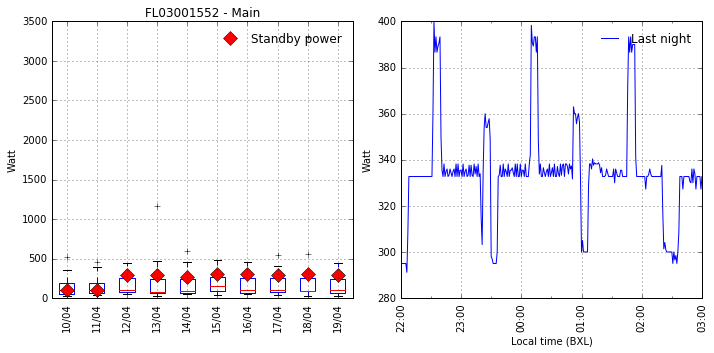

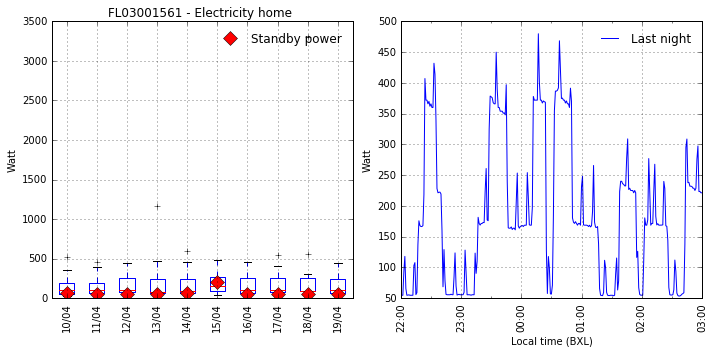

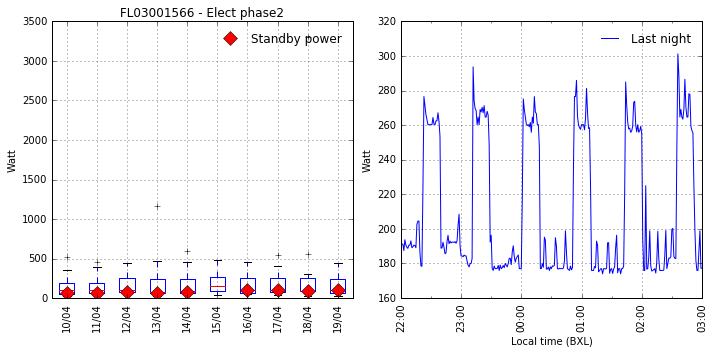

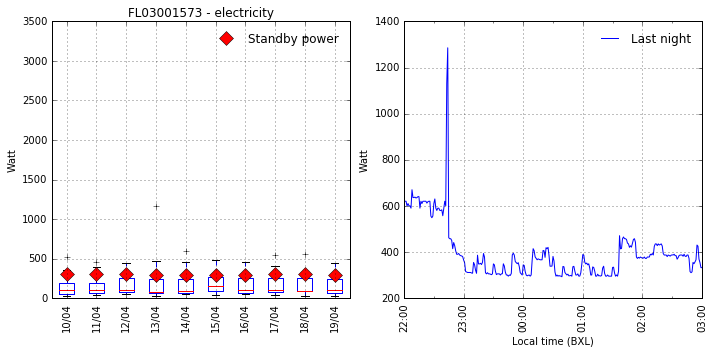

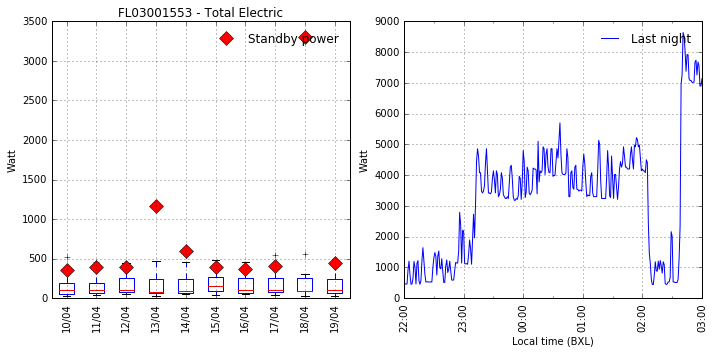

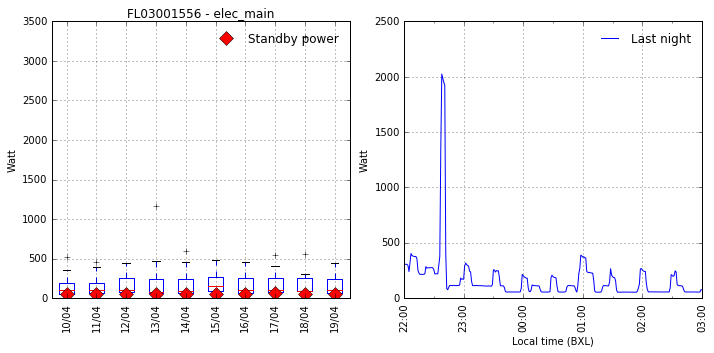

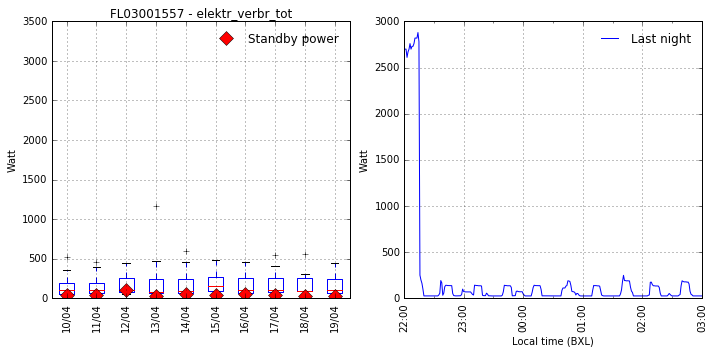

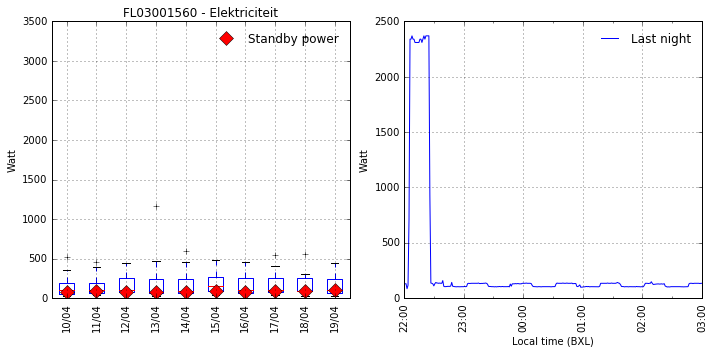

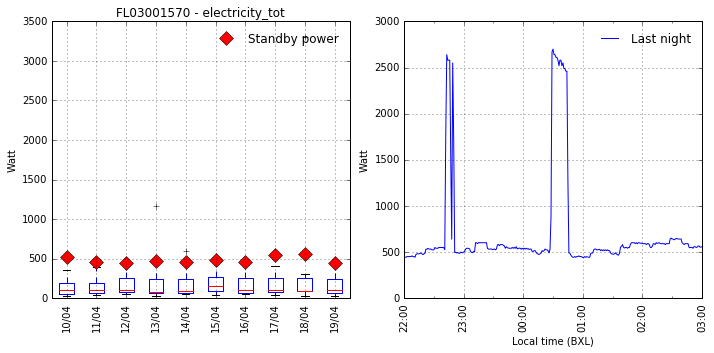

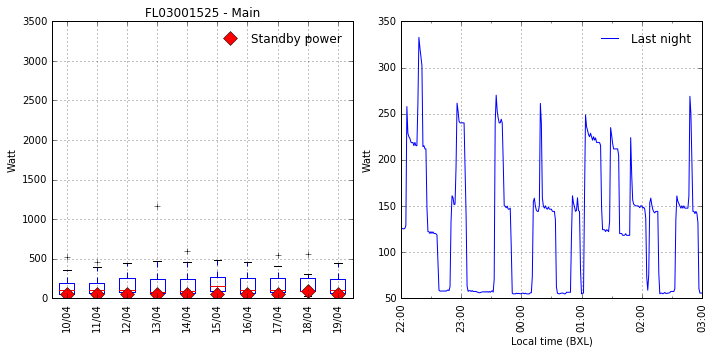

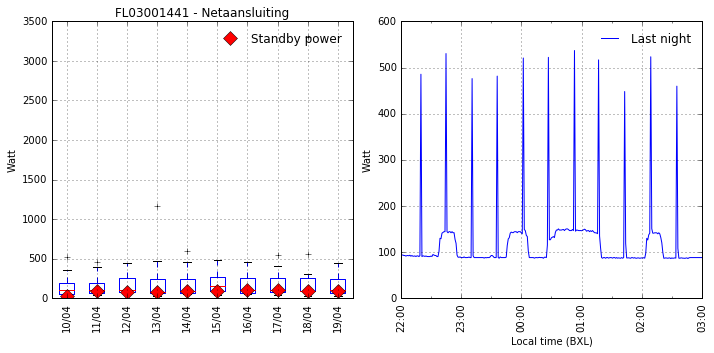

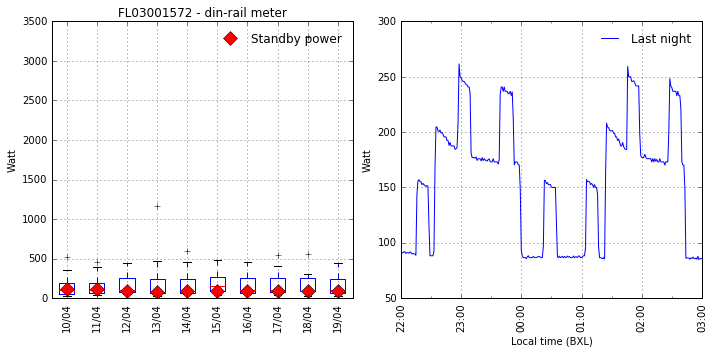

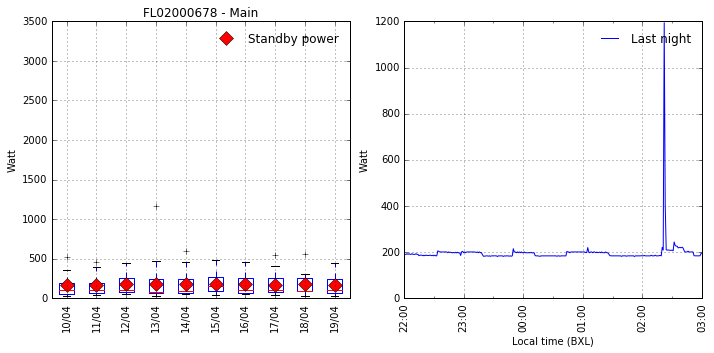

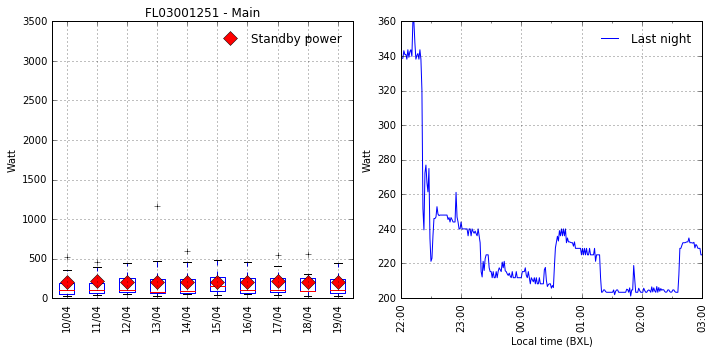

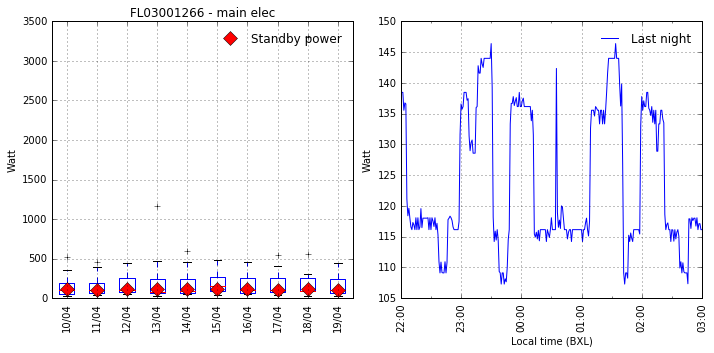

In [16]:
box = [dfdaymin_period.loc[i,:].dropna().values for i in dfdaymin_period.index]
for sensor in dfdaymin_period.columns:
    fig=plt.figure(figsize=(10,5))
    ax1=plt.subplot(121)
    ax1.boxplot(box, positions=range(len(box)), notch=False)
    ax1.plot(range(len(box)), dfdaymin_period[sensor], 'rD', ms=10, label='Standby power')
    xticks = [x.strftime(format='%d/%m') for x in dfdaymin_period.index]
    plt.xticks(range(len(box)), xticks, rotation='vertical')
    plt.title(hp.find_sensor(sensor).device.key + ' - ' + hp.find_sensor(sensor).description)
    ax1.grid()
    ax1.set_ylabel('Watt')
    plt.legend(numpoints=1, frameon=False)
    ax2=plt.subplot(122)
    try:
        ax2.plot_date(df_details[sensor].index, df_details[sensor].values, 'b-', label='Last night')
        ax2.xaxis_date(tz=BXL) #Put timeseries plot in local time
        # rotate the labels
        plt.xticks(rotation='vertical')
        ax2.set_ylabel('Watt')
        ax2.set_xlabel('Local time (BXL)')
        ax2.grid()
        
        xax = ax2.get_xaxis() # get the x-axis
        xax.set_major_locator(HourLocator())
        xax.set_minor_locator(MinuteLocator(30))
        
        adf = xax.get_major_formatter() # the the auto-formatter

        adf.scaled[1./24] = '%H:%M'  # set the < 1d scale to H:M
        adf.scaled[1.0] = '%Y-%m-%d' # set the > 1d < 1m scale to Y-m-d
        adf.scaled[30.] = '%Y-%m' # set the > 1m < 1Y scale to Y-m
        adf.scaled[365.] = '%Y' # set the > 1y scale to Y

        plt.legend(loc='upper right', frameon=False)
        plt.tight_layout()
    except Exception as e:
        print(e)
    else:
        plt.savefig(os.path.join(c.get('data', 'folder'), 'figures', 'standby_horizontal_'+sensor+'.png'), dpi=100)
        pass
    
    if not DEV:
        plt.close()

### Percentile approach.  Useful for longer time periods, but tweaking of graph still needed

In [17]:
# choose a period
look_back_days = 40
dt_start_of_period = dt_start_of_last_day - pd.Timedelta(days=look_back_days-1)
dfdaymin_period = dfdaymin.ix[dt_start_of_period:].dropna(axis=1, how='all')
df = dfdaymin_period.join(standby_statistics[['10%', '50%', '90%']], how='left')    

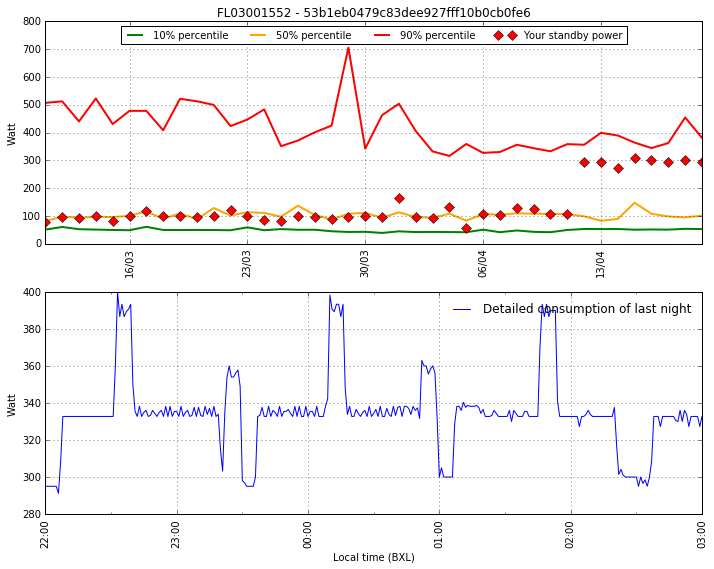

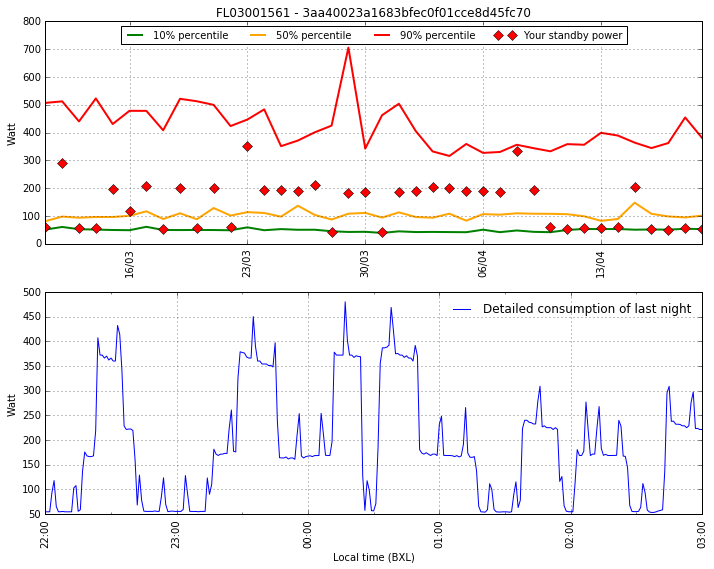

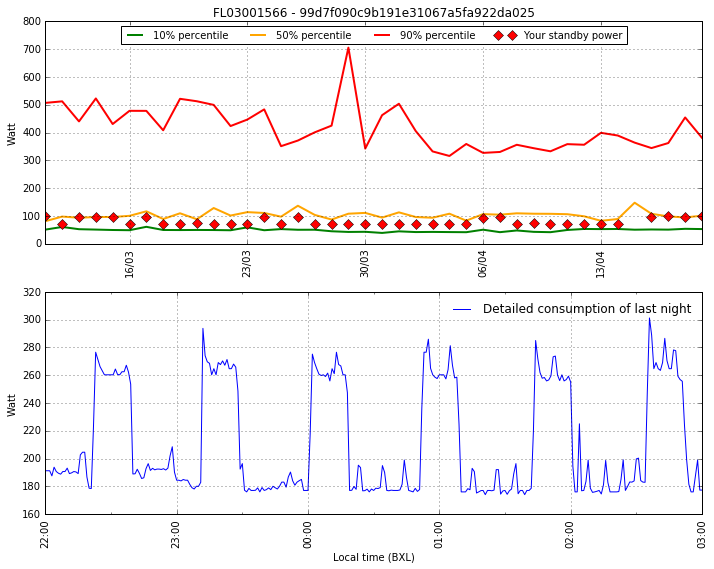

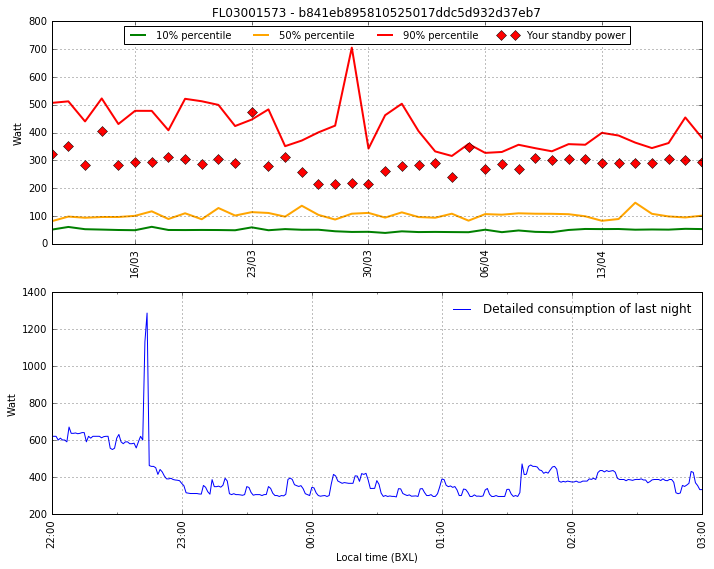

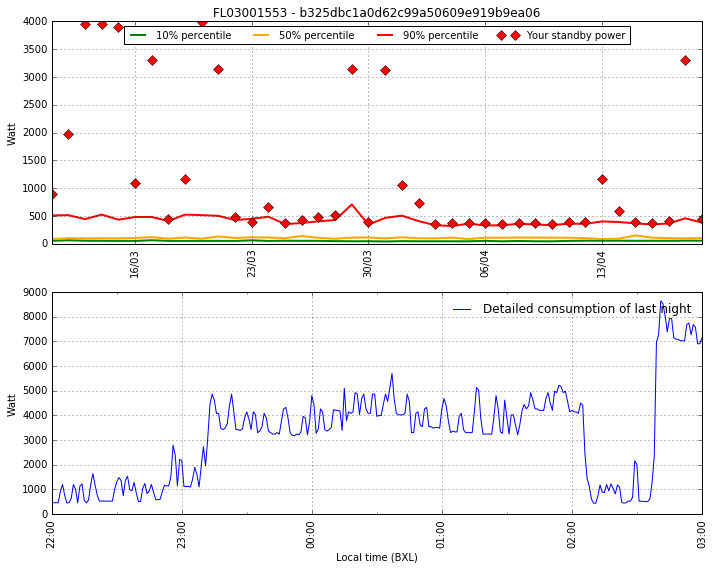

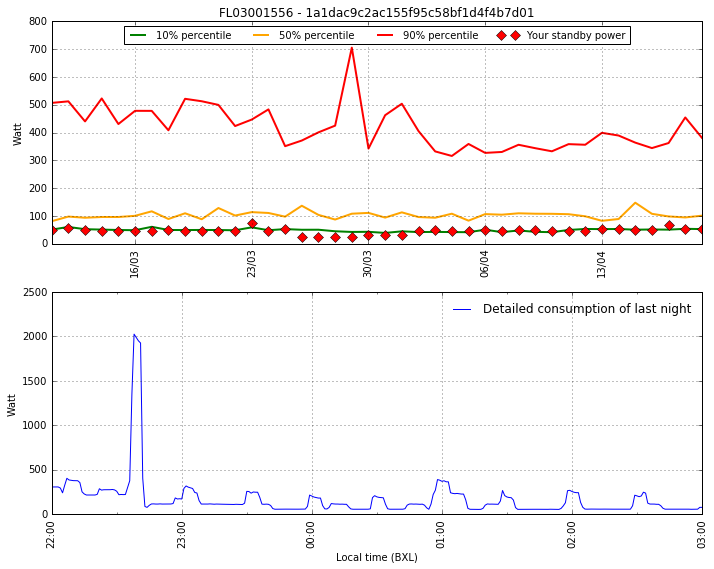

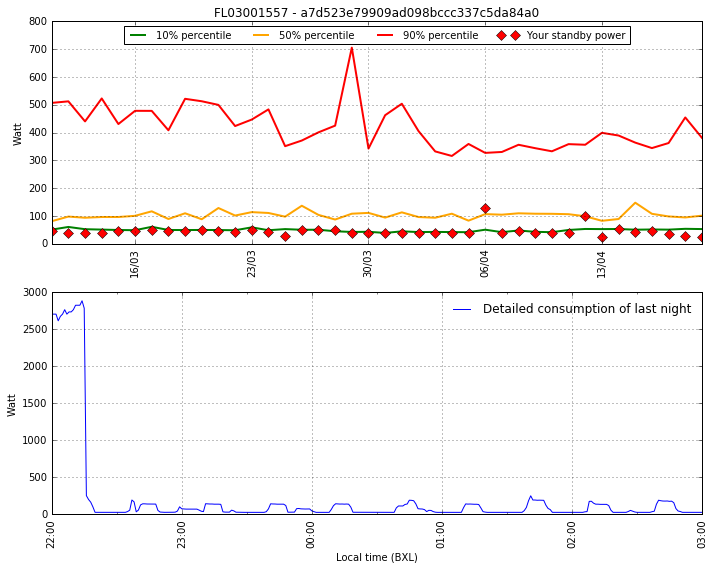

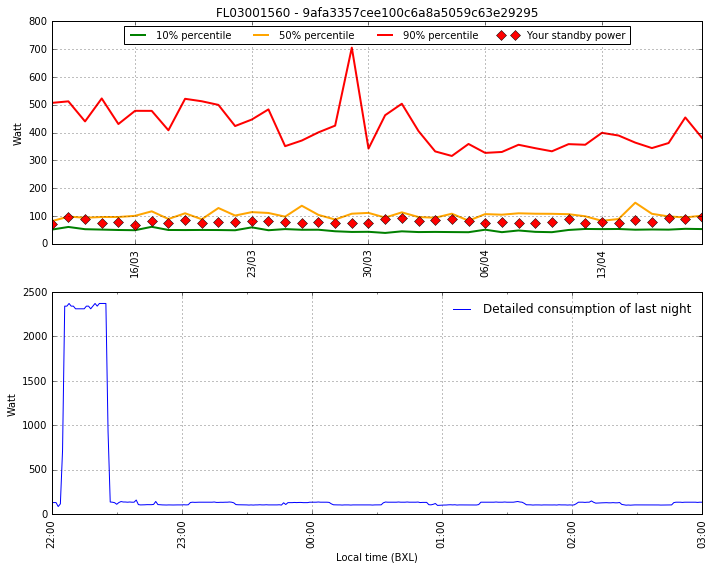

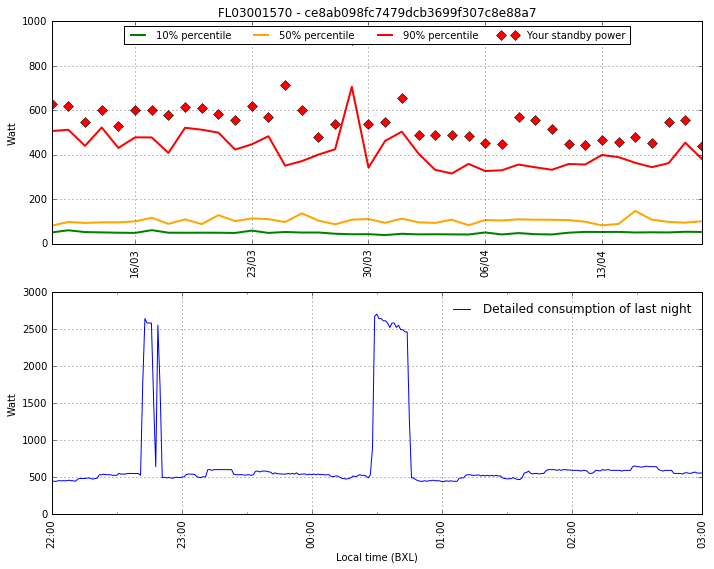

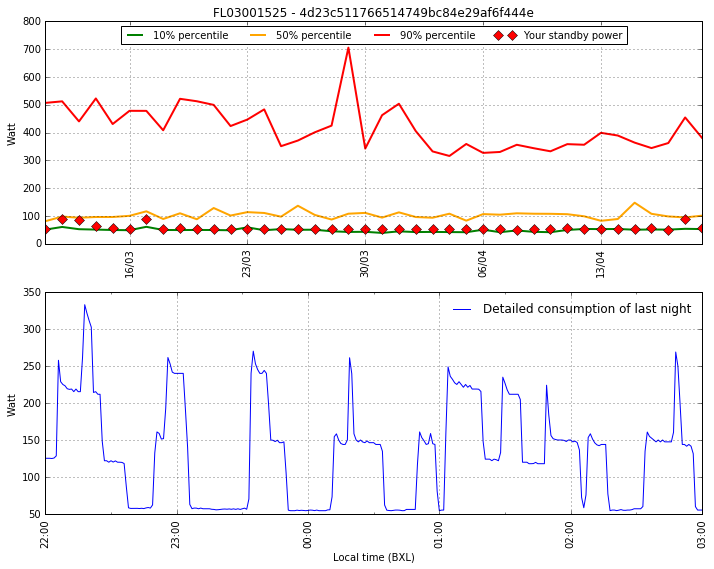

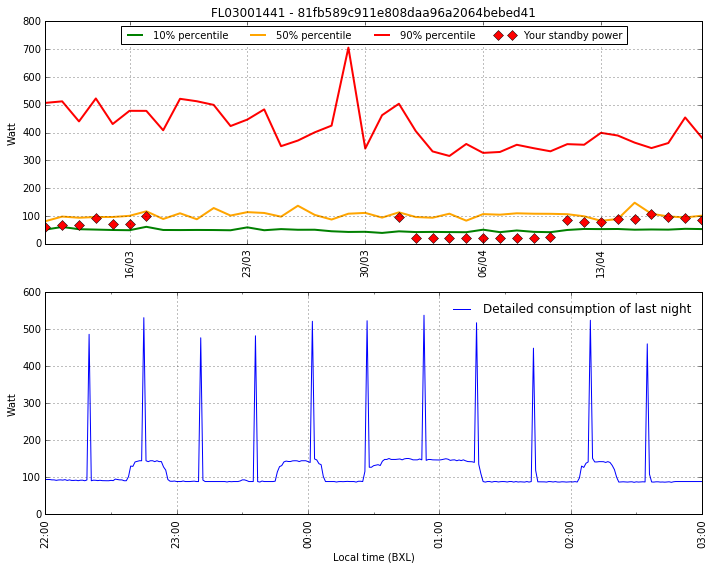

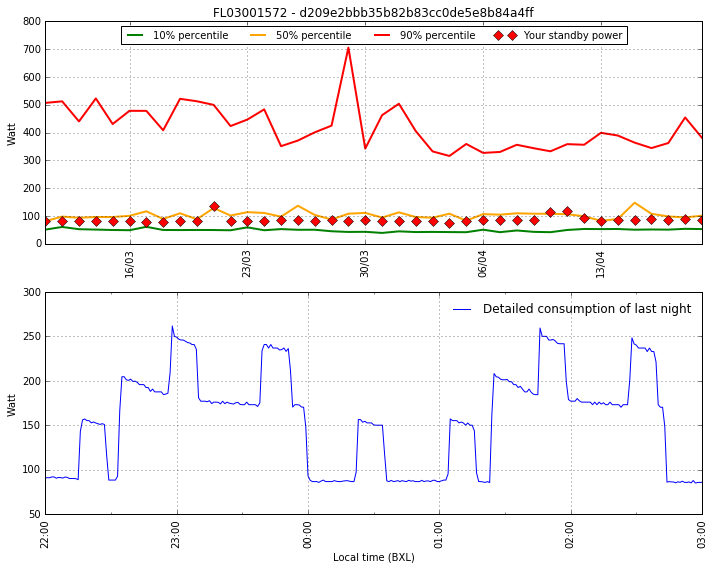

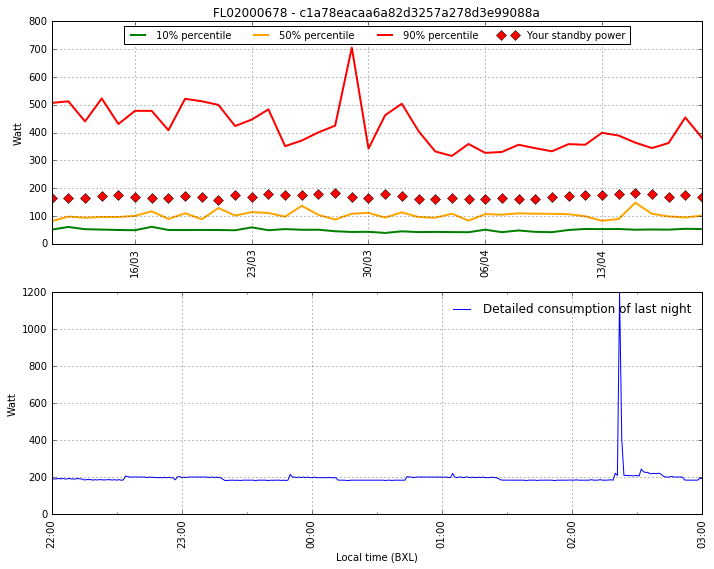

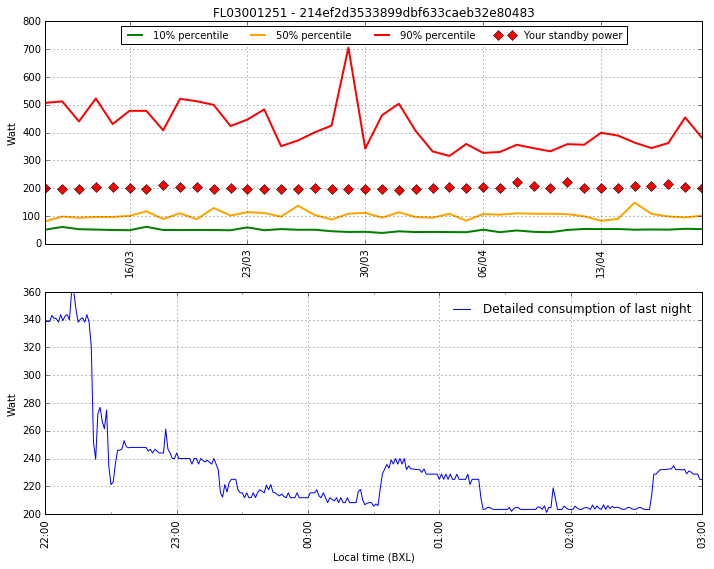

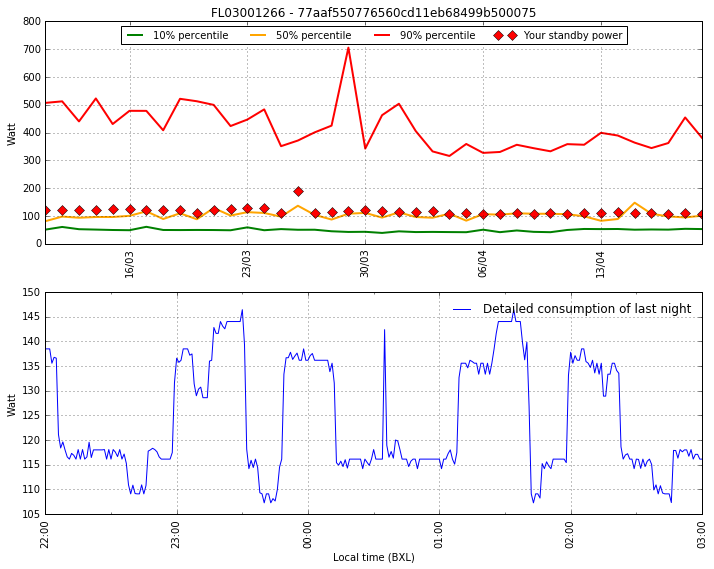

In [18]:
for sensor in dfdaymin_period.columns:
    plt.figure(figsize=(10,8))
    ax1=plt.subplot(211)
    ax1.plot_date(df.index, df[u'10%'], '-', lw=2, color='g', label=u'10% percentile')
    ax1.plot_date(df.index, df[u'50%'], '-', lw=2, color='orange', label=u'50% percentile')
    ax1.plot_date(df.index, df[u'90%'], '-', lw=2, color='r', label=u'90% percentile')
    ax1.plot_date(df.index, df[sensor], 'rD', ms=7, label='Your standby power') 
    ax1.legend(loc='upper center', ncol=4, prop={'size':10})
    locs, lables=plt.xticks()
    xticks = [x.strftime(format='%d/%m') for x in num2date(locs)]
    plt.xticks(locs, xticks, rotation='vertical')
    plt.title(hp.find_sensor(sensor).device.key + ' - ' + sensor)
    ax1.grid()
    ax1.set_ylabel('Watt')
    
    ax2=plt.subplot(212)
    try:
        ax2.plot_date(df_details[sensor].index, df_details[sensor].values, 'b-', label='Detailed consumption of last night')
        ax2.xaxis_date(tz=BXL) #Put timeseries plot in local time
        # rotate the labels
        plt.xticks(rotation='vertical')
        ax2.set_ylabel('Watt')
        ax2.set_xlabel('Local time (BXL)')
        ax2.grid()
        
        xax = ax2.get_xaxis() # get the x-axis
        xax.set_major_locator(HourLocator())
        xax.set_minor_locator(MinuteLocator(30))
        
        adf = xax.get_major_formatter() # the the auto-formatter

        adf.scaled[1./24] = '%H:%M'  # set the < 1d scale to H:M
        adf.scaled[1.0] = '%Y-%m-%d' # set the > 1d < 1m scale to Y-m-d
        adf.scaled[30.] = '%Y-%m' # set the > 1m < 1Y scale to Y-m
        adf.scaled[365.] = '%Y' # set the > 1y scale to Y
        
        plt.legend(loc='upper right', frameon=False)
        plt.tight_layout()
    except Exception as e:
        print(e)
    else:
        plt.savefig(os.path.join(c.get('data', 'folder'), 'figures', 'standby_vertical_'+sensor+'.png'), dpi=100)
        pass
    if not DEV:
        plt.close()

In [19]:
df_details.index

DatetimeIndex(['2016-04-18 22:00:00+00:00', '2016-04-18 22:01:00+00:00',
               '2016-04-18 22:02:00+00:00', '2016-04-18 22:03:00+00:00',
               '2016-04-18 22:04:00+00:00', '2016-04-18 22:05:00+00:00',
               '2016-04-18 22:06:00+00:00', '2016-04-18 22:07:00+00:00',
               '2016-04-18 22:08:00+00:00', '2016-04-18 22:09:00+00:00',
               ...
               '2016-04-19 02:51:00+00:00', '2016-04-19 02:52:00+00:00',
               '2016-04-19 02:53:00+00:00', '2016-04-19 02:54:00+00:00',
               '2016-04-19 02:55:00+00:00', '2016-04-19 02:56:00+00:00',
               '2016-04-19 02:57:00+00:00', '2016-04-19 02:58:00+00:00',
               '2016-04-19 02:59:00+00:00', '2016-04-19 03:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=301, freq='T')